In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

Generate Black Sholes

In [120]:
def simulate_Black_Scholes(S0, mu, sigma, T, dt) -> pd.DataFrame:
    # SIMULATE_BLACK_SHOLES calculates a temporal series of stock prices using the Black Scholes log normal model and the generated Brownian motion
    # stock_price_simulation = simulate_Black_Scholes(S0, mu, sigma, T, dt, rho)
    #
    # Arguments:
    #   S0    = integer, specifying the initial value of the underlying asset
    #   mu    = float, specifying the drift rate of the underlying asset 
    #   sigma = float, standard deviation of the underlying asset's return
    #   T     = integer, specifying the maximum modeling time. ex. if T = 2 then modelling time will run from 0 to 2
    #   dt    = float, specifying the length of each subinterval. ex. dt=10, then there will be 10 intervals of length 0.1 between two integers of modeling time 
    #   rho   = float, specifying the correlation coefficient of the Brownian motion. ex. rho = 0.4 means that two 
    #
    # Returns:
    #   stock_price_simulation = N x 2 pandas DataFrame where index is modeling time and values are a realisation of the uderlying's price
    #
    # Example:
    #   Model the price of a stock whitch is worth today 100. The market has a future annualized risk free rate of 5% and an annualized volatility of 30%. The user is interested in a price projection for the next 10 years in increments of 6 months (0.5 years)
    #   import pandas as pd
    #   import numpy as np
    #   simulate_Black_Scholes(100, 0.05, 0.3, 10, 0.5)   
    #   [out] = Time    Stock Price                
    #       0.0    100.000000
    #       0.5    131.721286
    #       1.0    124.924654
    #       1.5    209.302935
    #       2.0    222.085955
    #       2.5    208.085678
    #       3.0    165.550253
    #       3.5    239.512165
    #       4.0    176.886669
    #       4.5    148.687363
    #       5.0    181.235262
    #       5.5    164.280753
    #       6.0    172.861576
    #       6.5    170.698562
    #       7.0    141.613940
    #       7.5    121.070316
    #       8.0    116.508183
    #       8.5    104.524616
    #       9.0    146.124924
    #       9.5    202.368581
    #       10.0   262.282989
    # For more information see https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
    
    N = int(T / dt) # number of subintervals of length 1/dt between 0 and max modeling time T
   
    time, delta_t = np.linspace(0, T, num = N+1, retstep = True)
    S = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt)* np.random.normal(0, 1 , size= N))
    S = np.hstack([1, S])
    dict = {'Time' : time, 'Stock Price' : S0* S.cumprod(axis=0)}

    stock_price_simulation = pd.DataFrame.from_dict(data = dict)
    stock_price_simulation.set_index('Time', inplace = True)

    return stock_price_simulation

In [121]:
mu = 0.126 # 0.106
sigma = 0.221 # 0.181
nScen = 1000
sample_paths = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, 50, 1).values, columns=["Scenario0"])

for iStep in range(1,nScen):
    name = "Scenario"+ str(iStep)
    sample = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, 50, 1).values,columns=[name])
    sample_paths = sample_paths.join(sample)

In [122]:
# Prior distribution
prior_mean_1 = 0.2
prior_mean_2 = 0.3
prior_sd_1 = np.sqrt(0.2)
prior_sd_2 = np.sqrt(0.2)

# Proposal distribution
proposal_sd_1 = np.sqrt(0.5)
proposal_sd_2 = np.sqrt(0.2)

data1 = np.log(sample_paths)
data = data1.diff()[1:]

Normal distribution; log likelihood function

In [123]:
def lnorm_lf(mu,sigma,x,level):
# Log likelihood of a vector from the normal distribution
    n = x.size
    out = -n/2 * np.log(2*np.pi)-n*np.log(sigma) -1/(2 * np.power(sigma,2))*sum((x-(mu-sigma**2 /2))**2)

    return out


Normal distribution log likelihood function

In [124]:
def norm_lf(mu,sigma,x):
# Log likelihood of the normal distribution
    n = 1
    #n = x.size
    out = -n/2*np.log(2*np.pi)-n*np.log(sigma)-1/2 * 1/np.power(sigma,2)*(x-mu)**2
    return out

In [125]:
NSteps = 10000
result = np.zeros((NSteps,2))

# Starting position
muhatminus1 = 0.05
sigmahatminus1 = 0.2

for step in range(0,NSteps):
    muhat = np.random.normal(muhatminus1,proposal_sd_1)
    sigmahat = np.random.normal(sigmahatminus1,proposal_sd_2)

    if sigmahat<0:
        sigmahat = -sigmahat

    poslike = 0
    neglike = 0
    for iScen in range(0,nScen):
        name = "Scenario"+str(iScen)
        path = data[name].values
    
        poslike += lnorm_lf(muhat,sigmahat,path,sample_path[1:])
        neglike += lnorm_lf(muhatminus1,sigmahatminus1,path,sample_path[1:])
        
    poslognorm = poslike + norm_lf(prior_mean_1,prior_sd_1,muhat)+ norm_lf(prior_mean_2,prior_sd_2,sigmahat)
    neglognorm = neglike + norm_lf(prior_mean_1,prior_sd_1,muhatminus1) + norm_lf(prior_mean_2,prior_sd_2,sigmahatminus1)    
    
    alpha = poslognorm - neglognorm
    u = np.log(np.random.uniform(0,1,1))

    if u[0]>alpha:
        result[step,:] = [muhatminus1, sigmahatminus1]

    else:
        result[step,:] = [muhat, sigmahat]
        muhatminus1 = muhat
        sigmahatminus1 = sigmahat


In [126]:
pdResult = pd.DataFrame(result,columns = ['mu','sigma'])

In [127]:
print(pdResult['mu'])

0       0.050000
1       0.050000
2       0.050000
3       0.050000
4       0.050000
          ...   
9995    0.127026
9996    0.127026
9997    0.127026
9998    0.127026
9999    0.127026
Name: mu, Length: 10000, dtype: float64


In [128]:
print(pdResult['sigma'])

0       0.200000
1       0.200000
2       0.200000
3       0.200000
4       0.200000
          ...   
9995    0.222224
9996    0.222224
9997    0.222224
9998    0.222224
9999    0.222224
Name: sigma, Length: 10000, dtype: float64


In [129]:
# Exclude 95% of samples to only include the samples with maximum likelihood and to mitigate  the effect of initial conditions

RealStart = round(nScen*0.95)


(array([ 357.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 7667.,    0.,    0.,    0., 1026.]),
 array([0.21803662, 0.2183158 , 0.21859498, 0.21887417, 0.21915335,
        0.21943254, 0.21971172, 0.21999091, 0.22027009, 0.22054927,
        0.22082846, 0.22110764, 0.22138683, 0.22166601, 0.2219452 ,
        0.22222438]),
 <BarContainer object of 15 artists>)

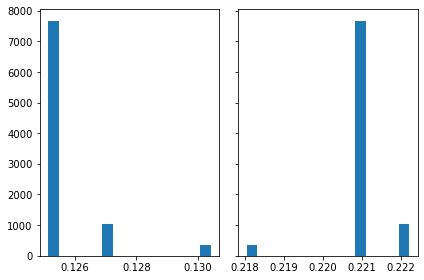

In [130]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(pdResult['mu'][RealStart:], bins=15)
axs[1].hist(pdResult['sigma'][RealStart:], bins=15)

In [131]:
pdResult[RealStart:].mean(axis=0)

mu       0.125544
sigma    0.220992
dtype: float64

In [132]:
pdResult[RealStart:].median(axis=0)

mu       0.125119
sigma    0.220964
dtype: float64